In [51]:
import pandas as pd
from tensorflow.keras.utils import get_file
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest

def getData(file_path):
    try:
        path = get_file(file_path, origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')

    except:
        print('Error Downloading')
        raise

    df = pd.read_csv(path, header = None)
    df.dropna(inplace = True, axis = 1)

    
    df.columns = [
        'duration',
        'protocol_type',
        'service',
        'flag',
        'src_bytes',
        'dst_bytes',
        'land',
        'wrong_fragment',
        'urgent',
        'hot',
        'num_failed_logins',
        'logged_in',
        'num_compromised',
        'root_shell',
        'su_attempted',
        'num_root',
        'num_file_creations',
        'num_shells',
        'num_access_files',
        'num_outbound_cmds',
        'is_host_login',
        'is_guest_login',
        'count',
        'srv_count',
        'serror_rate',
        'srv_serror_rate',
        'rerror_rate',
        'srv_rerror_rate',
        'same_srv_rate',
        'diff_srv_rate',
        'srv_diff_host_rate',
        'dst_host_count',
        'dst_host_srv_count',
        'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate',
        'dst_host_serror_rate',
        'dst_host_srv_serror_rate',
        'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate',
        'outcome'
    ]
    return df


def Preprocessing(df, cat_col_idx, get_dummy = True):
    df_columns = df.columns.tolist()
        
    numerical_columns = np.delete(df_columns, cat_col_idx)
   
    std = StandardScaler()
    
    for col in numerical_columns:
        df[col] = std.fit_transform(df[[col]])
    
    if get_dummy == True:
        
        def encode_text_dummy(df, name):
            dummies = pd.get_dummies(df[name])

            for x in dummies.columns:
                dummy_name = "{}-{}".format(name, x)
                df[dummy_name] = dummies[x]

            df.drop(name, axis = 1, inplace = True)

        encode_text_dummy(df, 'protocol_type')
        encode_text_dummy(df, 'service')
        encode_text_dummy(df, 'flag')
        encode_text_dummy(df, 'logged_in')
        encode_text_dummy(df, 'is_host_login')
        encode_text_dummy(df, 'is_guest_login')

        df.dropna(inplace = True, axis = 1)

        return df
    
    else:
        df.drop(columns = ['protocol_type', 'service', 'flag', 'logged_in',
                          'is_host_login', 'is_guest_login'], inplace = True)
        
        df.dropna(inplace = True, axis = 1)
        
        return df
        
def SplitData(df, testsize = None, seed = None, method = None):
    if testsize == None:
        raise AssertionError("Testsize must be defined.")
        
    else:
        pass
    
    if method == None:
        raise AssertionError("Method must be defined. (Outlier | Novelty)")
    if method == "Novelty":
        
        normal = df['outcome'] == 'normal.'
        attack = df['outcome'] != 'normal.'
    
        df.drop(columns = 'outcome', inplace = True)
    
        df_normal = df[normal]
        df_attack = df[attack]
        
        x_normal = df_normal.values
        x_attack = df_attack.values
    
        x_normal_train, x_normal_test = train_test_split(x_normal, test_size = testsize, random_state = seed)
    
        return x_normal_train, x_normal_test, x_attack
    
    elif method == "Outlier":
        
        train, test = train_test_split(df, test_size = testsize, random_state = seed)
        
        x_train = train.drop(columns = 'outcome')
        y_train = train['outcome']
        
        x_test = test.drop(columns = 'outcome')
        y_test = test['outcome']
        
        return x_train, x_test, y_train, y_test 

In [52]:
df = getData('kddcup.data_10_percent.gz')
df = Preprocessing(df, [1,2,3,6,11,20,21,41], get_dummy = False)

# Modeling

In [5]:
class SimpleIsolationForest:
    def __init__(self, df):
        self.df = df
        
    def Modeling(self, train_data, seed):
        self.train_data = train_data
        self.seed = seed
        
        model = IsolationForest(random_state = self.seed).fit(self.train_data)
        
        self.model = model
    
    def Prediction(self, test_data, data_type):
        self.test_data = test_data
        
        def ConvertLabel(x):
            if x == -1:
                return 1
    
            else:
                return 0
            
        function = np.vectorize(ConvertLabel)
            
        if data_type == None:
            raise AssertionError('Data Type must be defined.')
            
        elif data_type == 'Insample':
            pred = self.model.predict(self.test_data)
            pred = function(pred)
            pred = list(pred)
            
            print('Insample Classification Result \n')
            print('Normal Value: {}'.format(pred.count(0)))
            print('Anomlay Value: {}'.format(pred.count(1)))

        elif data_type == 'OutOfSample':
            pred = self.model.predict(self.test_data)
            pred = function(pred)
            pred = list(pred)
            
            print('Insample Classification Result \n')
            print('Normal Value: {}'.format(pred.count(0)))
            print('Anomlay Value: {}'.format(pred.count(1)))
            
        elif data_type == 'Attack':
            pred = self.model.predict(self.test_data)
            pred = function(pred)
            pred = list(pred)
            
            print('Insample Classification Result \n')
            print('Normal Value: {}'.format(pred.count(0)))
            print('Anomlay Value: {}'.format(pred.count(1)))
            
            self.pred = pred
            
            return self.pred

In [73]:
tmp = SimpleIsolationForest(X_normal_train)

In [74]:
tmp.Modeling(X_normal_train, seed = 42)

In [75]:
tmp.Prediction(X_normal_test, data_type = 'OutOfSample')

Insample Classification Result 

Normal Value: 21946
Anomlay Value: 2374


In [76]:
tmp.Prediction(X_normal_train, data_type = 'Insample')

Insample Classification Result 

Normal Value: 65667
Anomlay Value: 7291


# Viz

In [53]:
x_train, x_test, y_train, y_test = SplitData(df, testsize = 0.25, seed = 42, method = "Outlier")

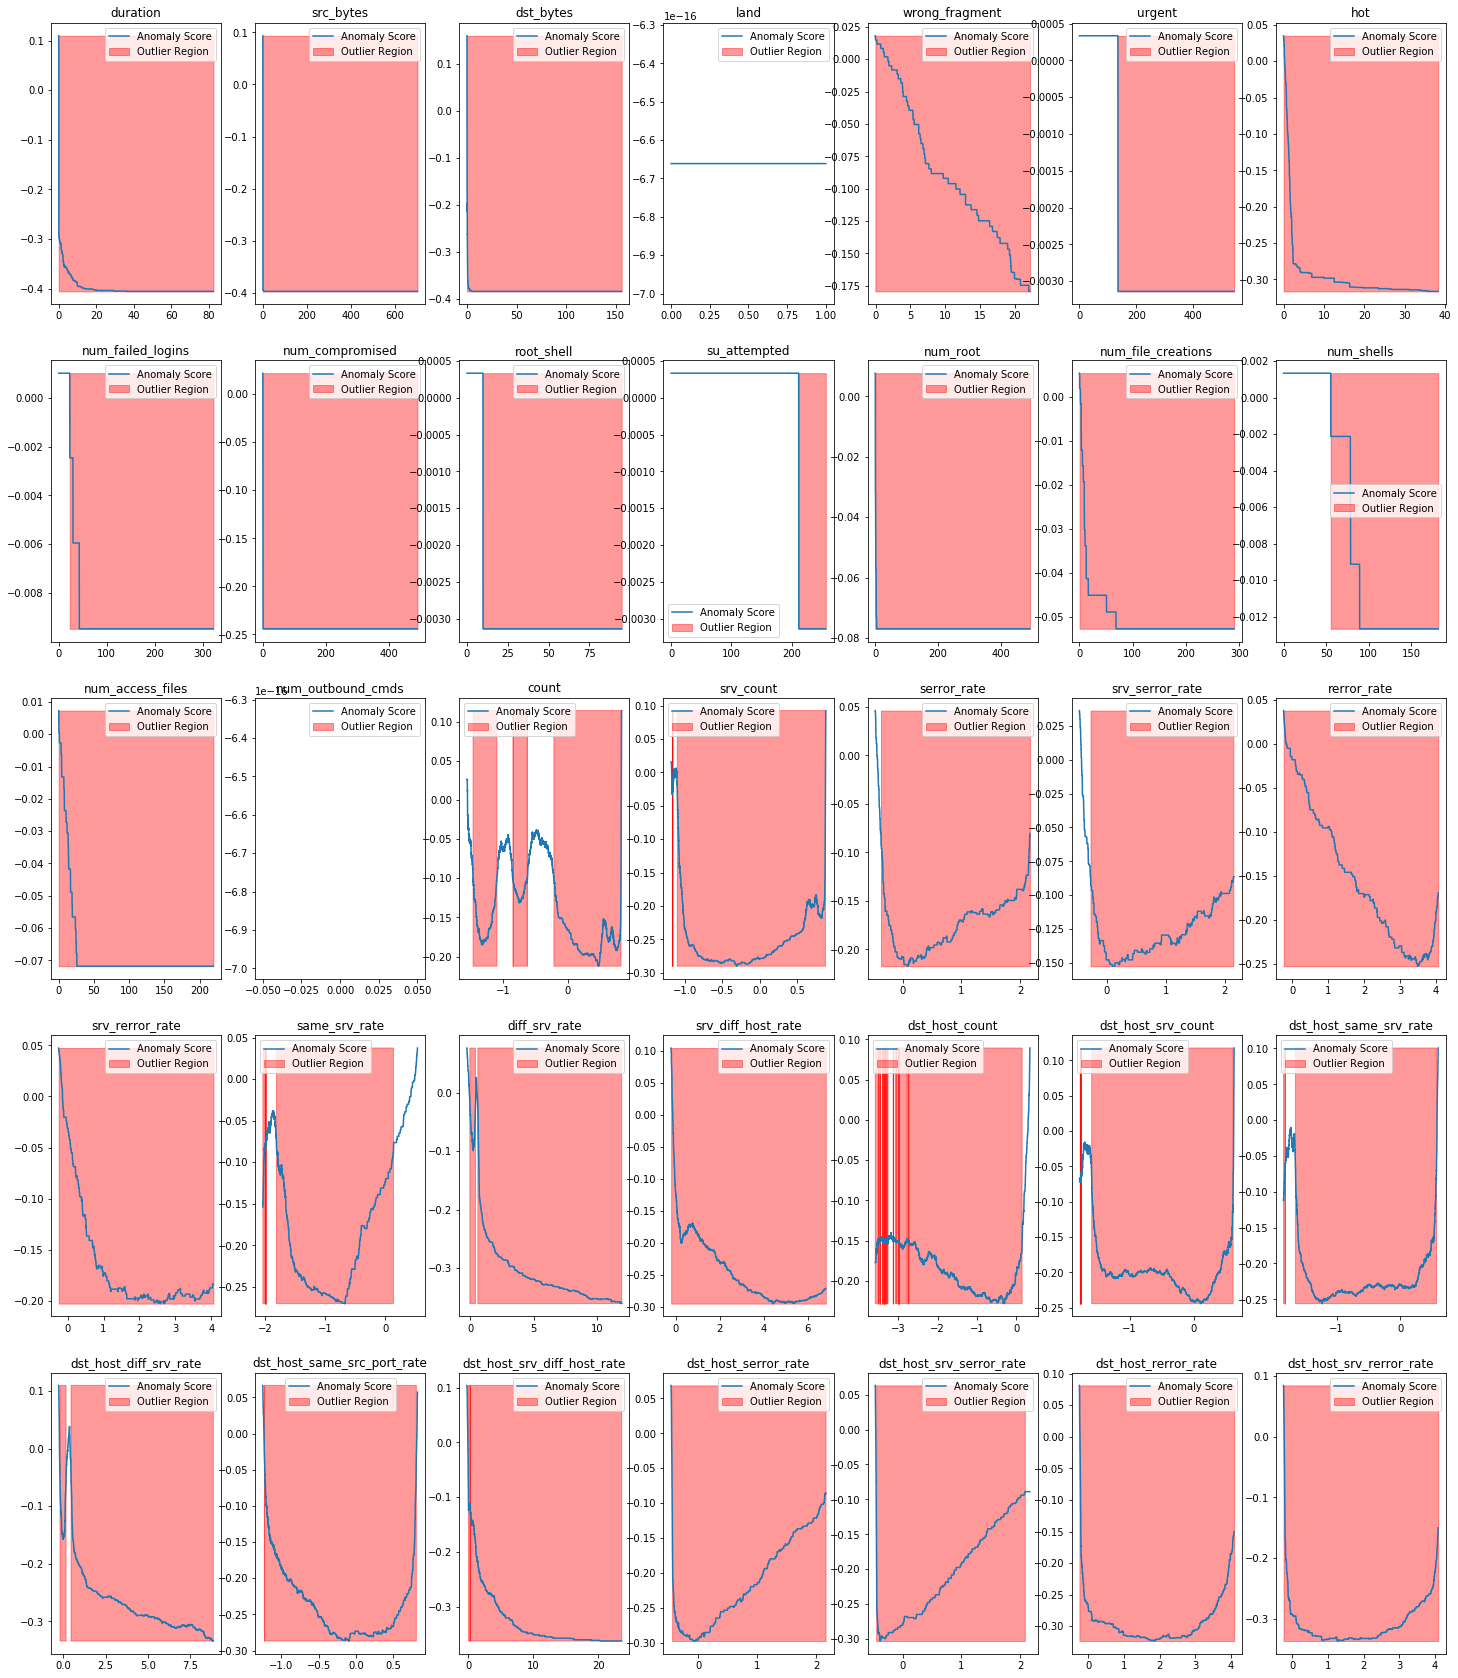

In [55]:
fig, axs = plt.subplots(5, 7, figsize = (25, 30), facecolor = 'w', edgecolor = 'k')
axs = axs.ravel()

for i, columns in enumerate(x_train.columns):
    isolation_forest = IsolationForest()
    isolation_forest.fit(x_train[columns].values.reshape(-1,1))
    
    xx = np.linspace(x_train[columns].min(), df[columns].max(), len(x_train)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label = 'Anomaly Score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                       where = outlier == -1, color = 'r',
                       alpha = .4, label = 'Outlier Region')
    
    axs[i].legend()
    axs[i].set_title(columns)